In [10]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from music21 import stream, note, clef, tempo, metadata, environment
from librosa import note_to_midi, midi_to_note
import os
from IPython.display import Image, display

# ---------- CONFIG ----------
VIDEO_PATH = '../../Data/video/piano_visualizer.mp4'
FPS = 30
COLOR_DIFF_THRESHOLD = 40
MIN_DURATION = 0.05
MAX_COLOR_GROUPS = 6
DEFAULT_NUM_KEYS = 88

# Set MuseScore path if needed (for portable use)
env = environment.UserSettings()
env['musescoreDirectPNGPath'] = os.path.abspath("../../MuseScorePortable/App/MuseScore/bin/MuseScore4.exe")
env['musicxmlPath'] = os.path.abspath("../../MuseScorePortable/App/MuseScore/bin/MuseScore4.exe")

# Create output_AUtoSHEET directory
os.makedirs("../AUtoSHEET/output_AUtoSHEET", exist_ok=True)

# ---------- HELPER FUNCTIONS ----------
def get_dominant_color(img, k=1):
    pixels = img.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, n_init='auto').fit(pixels)
    return kmeans.cluster_centers_[0]

def pos_to_note_name(rel_pos, base_note='A0', num_keys=88):
    base_midi = note_to_midi(base_note)
    midi_note = int(base_midi + rel_pos * num_keys)
    return midi_to_note(midi_note)

def find_best_k(color_list, max_k=6):
    best_k = 2
    best_score = -1
    for k in range(2, min(max_k, len(color_list)) + 1):
        kmeans = KMeans(n_clusters=k, n_init='auto').fit(color_list)
        score = silhouette_score(color_list, kmeans.labels_)
        if score > best_score:
            best_k = k
            best_score = score
    return best_k

def detect_piano_keys_auto(roi, min_width=5, min_height_ratio=0.4):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0, ksize=3)
    sobelx = np.uint8(np.absolute(sobelx))
    _, thresh = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 10))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    key_boxes = []
    roi_height, roi_width = roi.shape[:2]
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > min_width and h > roi_height * min_height_ratio:
            key_boxes.append((x, x + w))

    key_boxes = sorted(key_boxes)
    merged = []
    for box in key_boxes:
        if not merged or box[0] > merged[-1][1]:
            merged.append(box)
        else:
            merged[-1] = (merged[-1][0], max(merged[-1][1], box[1]))

    key_boundaries = [x1 for x1, _ in merged]
    if merged:
        key_boundaries.append(merged[-1][1])
    return key_boundaries

# ---------- LOAD VIDEO ----------
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
if not ret:
    raise Exception("Gagal membuka video")

frame_height, frame_width = frame.shape[:2]

# ---------- PIANO BOX MANUAL FALLBACK (bottom 25%) ----------
h_roi = frame_height // 4
w_roi = frame_width
x_roi = 0
y_roi = frame_height - h_roi
roi = frame[y_roi:y_roi + h_roi, x_roi:x_roi + w_roi]

# ---------- AUTO DETECT KEYS ----------
key_boundaries = detect_piano_keys_auto(roi)

if len(key_boundaries) < 2:
    print("⚠️ Tidak cukup tuts terdeteksi. Membagi area menjadi 88 tuts secara merata.")
    key_boundaries = [int(i * w_roi / DEFAULT_NUM_KEYS) for i in range(DEFAULT_NUM_KEYS + 1)]

num_keys = len(key_boundaries) - 1

# ---------- GET IDLE BRIGHTNESS ----------
idle_brightness = []
for i in range(num_keys):
    x1 = key_boundaries[i]
    x2 = key_boundaries[i + 1]
    key_img = cv2.cvtColor(roi[:, x1:x2], cv2.COLOR_BGR2GRAY)
    mean_bright = np.mean(key_img)
    idle_brightness.append(mean_bright)

# ---------- READ ALL FRAMES AND DETECT NOTES ----------
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
frame_number = 0
pressed = [False] * num_keys
start_times = [None] * num_keys

note_buffer = []
color_list = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_number += 1
    current_time = frame_number / FPS
    roi = frame[y_roi:y_roi + h_roi, x_roi:x_roi + w_roi]

    for i in range(num_keys):
        x1 = key_boundaries[i]
        x2 = key_boundaries[i + 1]
        key_roi = roi[:, x1:x2]
        key_gray = cv2.cvtColor(key_roi, cv2.COLOR_BGR2GRAY)
        current_bright = np.mean(key_gray)
        bright_diff = current_bright - idle_brightness[i]

        if bright_diff > COLOR_DIFF_THRESHOLD:
            if not pressed[i]:
                pressed[i] = True
                start_times[i] = current_time
        else:
            if pressed[i]:
                pressed[i] = False
                duration = current_time - start_times[i]
                if duration >= MIN_DURATION:
                    dominant_color = get_dominant_color(key_roi)
                    center_x = (x1 + x2) / 2 + x_roi
                    rel_pos = center_x / frame_width
                    note_buffer.append((rel_pos, start_times[i], duration, dominant_color))
                    color_list.append(dominant_color)

cap.release()

# ---------- CLUSTER COLORS DYNAMICALLY ----------
best_k = find_best_k(color_list, max_k=MAX_COLOR_GROUPS)
kmeans = KMeans(n_clusters=best_k, n_init='auto').fit(color_list)
labels = kmeans.labels_

# ---------- BUILD MUSIC STREAM ----------
streams = [stream.Part() for _ in range(best_k)]
clefs_list = [clef.TrebleClef(), clef.BassClef(), clef.TrebleClef(), clef.BassClef()]
tempo_mark = tempo.MetronomeMark(number=100)

for i, s in enumerate(streams):
    s.insert(0, clefs_list[i % len(clefs_list)])
    s.insert(0, tempo_mark)

for idx, (rel_pos, start, dur, color) in enumerate(note_buffer):
    cluster_idx = labels[idx]
    try:
        pitch = pos_to_note_name(rel_pos)
        n = note.Note(pitch)
        n.quarterLength = round(dur * 2) / 2
        streams[cluster_idx].append(n)
    except:
        continue

# ---------- SAVE MUSICXML ----------
score = stream.Score()
for s in streams:
    score.insert(0, s)

score.metadata = metadata.Metadata()
score.metadata.title = "Dynamic Multi-Color Piano Detection"
score.metadata.composer = "Generated by AI"

output_xml = "output_SYNtoSHEET/output_dynamic_multicolor.xml"
output_png = "output_SYNtoSHEET/output_dynamic_multicolor.png"

score.write('musicxml', fp=output_xml)
score.write('musicxml.png', fp=output_png)

print(f"\n✅ MusicXML berhasil dibuat dengan {best_k} warna unik: {output_xml}")
display(Image(filename=output_png))


✅ MusicXML berhasil dibuat dengan 2 warna unik: output/output_dynamic_multicolor.xml


FileNotFoundError: [Errno 2] No such file or directory: 'output/output_dynamic_multicolor.png'

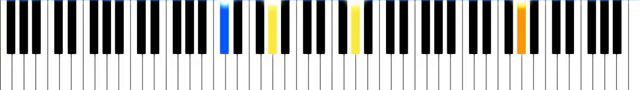

✅ ROI piano ditampilkan. Cek hasilnya sebelum lanjut ke deteksi tuts.


In [13]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from music21 import stream, note, clef, tempo, metadata, environment
from librosa import note_to_midi, midi_to_note
import os
from IPython.display import Image, display

# ---------- CONFIG ----------
VIDEO_PATH = '../../Data/video/piano_visualizer.mp4'
FPS = 30
COLOR_DIFF_THRESHOLD = 40
MIN_DURATION = 0.05
MAX_COLOR_GROUPS = 6
DEFAULT_NUM_KEYS = 88

# Set MuseScore path if needed (for portable use)
env = environment.UserSettings()
env['musescoreDirectPNGPath'] = os.path.abspath("../../MuseScorePortable/App/MuseScore/bin/MuseScore4.exe")
env['musicxmlPath'] = os.path.abspath("../../MuseScorePortable/App/MuseScore/bin/MuseScore4.exe")

# Create output_SYNtoSHEET directory
os.makedirs("output_SYNtoSHEET", exist_ok=True)

# ---------- HELPER FUNCTIONS ----------
def get_dominant_color(img, k=1):
    pixels = img.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, n_init='auto').fit(pixels)
    return kmeans.cluster_centers_[0]

def pos_to_note_name(rel_pos, base_note='A0', num_keys=88):
    base_midi = note_to_midi(base_note)
    midi_note = int(base_midi + rel_pos * num_keys)
    return midi_to_note(midi_note)

def find_best_k(color_list, max_k=6):
    best_k = 2
    best_score = -1
    for k in range(2, min(max_k, len(color_list)) + 1):
        kmeans = KMeans(n_clusters=k, n_init='auto').fit(color_list)
        score = silhouette_score(color_list, kmeans.labels_)
        if score > best_score:
            best_k = k
            best_score = score
    return best_k

def detect_piano_keys_auto(roi, min_width=5, min_height_ratio=0.4):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0, ksize=3)
    sobelx = np.uint8(np.absolute(sobelx))
    _, thresh = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 10))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    key_boxes = []
    roi_height, roi_width = roi.shape[:2]
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > min_width and h > roi_height * min_height_ratio:
            key_boxes.append((x, x + w))

    key_boxes = sorted(key_boxes)
    merged = []
    for box in key_boxes:
        if not merged or box[0] > merged[-1][1]:
            merged.append(box)
        else:
            merged[-1] = (merged[-1][0], max(merged[-1][1], box[1]))

    key_boundaries = [x1 for x1, _ in merged]
    if merged:
        key_boundaries.append(merged[-1][1])
    return key_boundaries

# ---------- LOAD VIDEO ----------
cap = cv2.VideoCapture(VIDEO_PATH)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

# Ambil frame dari tengah video
middle_frame_idx = total_frames // 2
cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)
ret, frame = cap.read()
if not ret:
    raise Exception("Gagal membuka frame tengah video")

# ---------- PIANO BOX (bottom 25%) ----------
h_roi = frame_height // 4
w_roi = frame_width
x_roi = 0
y_roi = frame_height - h_roi
roi = frame[y_roi:y_roi + h_roi, x_roi:x_roi + w_roi]

# Simpan gambar hasil ROI piano
cv2.imwrite("output_SYNtoSHEET/piano_region_preview.png", roi)
display(Image(filename="output_SYNtoSHEET/piano_region_preview.png"))
print("✅ ROI piano ditampilkan. Cek hasilnya sebelum lanjut ke deteksi tuts.")

# Keluar lebih awal untuk validasi manual ROI sebelum lanjut
cap.release()

# Jika validasi berhasil, barulah lanjutkan ke deteksi tuts dan ekstraksi
# return output_xml, output_png


Frame 0: Putih=0.00, Hitam=0 → ❌
Frame 1: Putih=0.00, Hitam=0 → ❌
Frame 2: Putih=0.00, Hitam=0 → ❌
Frame 3: Putih=0.00, Hitam=0 → ❌
Frame 4: Putih=0.00, Hitam=0 → ❌
Frame 5: Putih=0.00, Hitam=0 → ❌
Frame 6: Putih=0.00, Hitam=0 → ❌
Frame 7: Putih=0.00, Hitam=0 → ❌
Frame 8: Putih=0.00, Hitam=26 → ❌
Frame 9: Putih=0.00, Hitam=51 → ❌
Frame 10: Putih=0.00, Hitam=41 → ❌
Frame 11: Putih=0.00, Hitam=38 → ❌
Frame 12: Putih=0.00, Hitam=38 → ❌
Frame 13: Putih=0.00, Hitam=38 → ❌
Frame 14: Putih=0.03, Hitam=38 → ❌
Frame 15: Putih=0.58, Hitam=38 → ✅

✅ Frame piano ditemukan di index ke-15



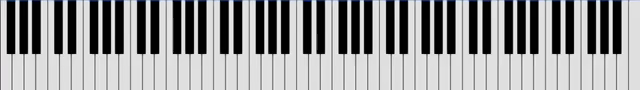

Hitam: 38, Putih estimasi: 54


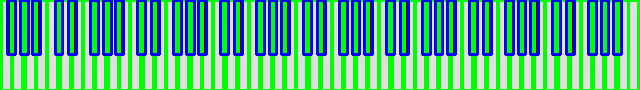

In [27]:
import cv2
import numpy as np
import os
from IPython.display import Image, display

# ---------- CONFIG ----------
VIDEO_PATH = '../../Data/video/piano_visualizer.mp4'
MAX_FRAMES = 500
MIN_BLACK_KEYS = 10
WHITE_PIXEL_RATIO = 0.5
ROI_HEIGHT_RATIO = 0.25

# ---------- OUTPUT DIR ----------
os.makedirs("output_SYNtoSHEET", exist_ok=True)

# ---------- Fungsi: Deteksi apakah frame seperti piano ----------
def is_piano_like_frame(roi, min_black_keys=10, white_pixel_ratio=0.5):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Hitung dominasi warna putih
    white_pixels = np.sum(gray > 200)
    total_pixels = gray.shape[0] * gray.shape[1]
    white_ratio = white_pixels / total_pixels

    # Deteksi hitam (tuts hitam)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    black_keys = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if h > roi.shape[0] * 0.5 and w < roi.shape[1] * 0.05:
            black_keys.append((x, y, w, h))

    return white_ratio > white_pixel_ratio and len(black_keys) >= min_black_keys, white_ratio, len(black_keys)

# ---------- Fungsi: Temukan frame pertama yang mirip piano ----------
def find_frame_with_piano_by_whiteness(video_path, max_frames=500, debug=False):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise Exception(f"❌ Gagal membuka video: {video_path}")

    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h_roi = int(frame_height * ROI_HEIGHT_RATIO)

    frame_found = None
    frame_index = 0

    while frame_index < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        roi = frame[frame_height - h_roi:frame_height, 0:frame_width]
        is_piano, white_ratio, num_black = is_piano_like_frame(roi)

        if debug:
            print(f"Frame {frame_index}: Putih={white_ratio:.2f}, Hitam={num_black} → {'✅' if is_piano else '❌'}")

        if is_piano:
            frame_found = frame
            break

        frame_index += 1

    cap.release()
    return frame_found, frame_index

# ---------- Fungsi: Deteksi tuts putih & hitam ----------
def detect_keys_from_black_spacing(image, debug=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black_keys = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if h > image.shape[0] * 0.5 and w < image.shape[1] * 0.05:
            black_keys.append((x, y, w, h))

    black_keys = sorted(black_keys, key=lambda b: b[0])
    black_x_centers = [x + w // 2 for x, y, w, h in black_keys]

    white_keys = []
    if len(black_x_centers) >= 2:
        dists = [black_x_centers[i+1] - black_x_centers[i] for i in range(len(black_x_centers)-1)]
        avg_gap = np.median(dists)
        est_white_width = int(avg_gap * 0.75)

        # 1️⃣ DETEKSI KIRI (sebelum black key pertama)
        first_black_center = black_x_centers[0]
        if first_black_center - est_white_width > 0:
            white_keys.append((first_black_center - est_white_width, 0, est_white_width, image.shape[0]))

        # 2️⃣ DETEKSI DI ANTARA TUTS HITAM
        for i in range(len(black_x_centers) - 1):
            x1 = black_x_centers[i]
            x2 = black_x_centers[i+1]
            gap = x2 - x1

            if gap < avg_gap * 1.5:
                # Normal case: 1 white key
                white_keys.append((x1 + (gap // 2) - (est_white_width // 2), 0, est_white_width, image.shape[0]))
            else:
                # E-F atau B-C case: 2 white keys
                half_gap = gap // 2
                white_keys.append((x1 + (half_gap // 2) - (est_white_width // 2), 0, est_white_width, image.shape[0]))
                white_keys.append((x1 + half_gap + (half_gap // 2) - (est_white_width // 2), 0, est_white_width, image.shape[0]))

        # 3️⃣ DETEKSI KANAN (setelah black key terakhir)
        last_black_center = black_x_centers[-1]
        last_white_right = white_keys[-1][0] + white_keys[-1][2]
        if last_white_right < image.shape[1] - est_white_width * 0.5:
            white_keys.append((last_black_center + 1, 0, est_white_width, image.shape[0]))

        # 4️⃣ EKSTRA WHITE KEY KANAN JIKA MASIH ADA RUANG
        last_white_right = white_keys[-1][0] + white_keys[-1][2]
        if last_white_right + est_white_width * 0.5 < image.shape[1]:
            white_keys.append((last_white_right, 0, est_white_width, image.shape[0]))

    # Gambar hasil
    vis = image.copy()
    for x, y, w, h in white_keys:
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
    for x, y, w, h in black_keys:
        cv2.rectangle(vis, (x, y), (x + w, y + h), (255, 0, 0), 2)

    if debug:
        print(f"Hitam: {len(black_keys)}, Putih estimasi: {len(white_keys)}")

    return vis, white_keys, black_keys



# ---------- MAIN ----------
frame, found_index = find_frame_with_piano_by_whiteness(VIDEO_PATH, max_frames=MAX_FRAMES, debug=True)

if frame is None:
    raise Exception("❌ Tidak ditemukan frame dengan pola piano.")

print(f"\n✅ Frame piano ditemukan di index ke-{found_index}\n")

frame_height, frame_width = frame.shape[:2]
h_roi = int(frame_height * ROI_HEIGHT_RATIO)
roi = frame[frame_height - h_roi:, :]

cv2.imwrite("output_SYNtoSHEET/piano_frame.png", roi)
display(Image(filename="output_SYNtoSHEET/piano_frame.png"))

# Deteksi tuts dari ROI
detected_img, white_keys, black_keys = detect_keys_from_black_spacing(roi, debug=True)
cv2.imwrite("output_SYNtoSHEET/detected_from_spacing.png", detected_img)
display(Image(filename="output_SYNtoSHEET/detected_from_spacing.png"))


🎹 Synthesia Video to Sheet Music Converter

🔍 Detecting piano region...
Frame 0 Y:0: White=0.00, Black=0, Score=0.00
Frame 0 Y:50: White=0.00, Black=0, Score=0.00
Frame 0 Y:100: White=0.00, Black=0, Score=0.00
Frame 0 Y:150: White=0.00, Black=0, Score=0.00
Frame 0 Y:200: White=0.00, Black=0, Score=0.00
Frame 0 Y:250: White=0.00, Black=0, Score=0.00
Frame 1 Y:0: White=0.00, Black=0, Score=0.00
Frame 1 Y:50: White=0.00, Black=0, Score=0.00
Frame 1 Y:100: White=0.00, Black=0, Score=0.00
Frame 1 Y:150: White=0.00, Black=0, Score=0.00
Frame 1 Y:200: White=0.00, Black=0, Score=0.00
Frame 1 Y:250: White=0.00, Black=0, Score=0.00
Frame 2 Y:0: White=0.00, Black=0, Score=0.00
Frame 2 Y:50: White=0.00, Black=0, Score=0.00
Frame 2 Y:100: White=0.00, Black=0, Score=0.00
Frame 2 Y:150: White=0.00, Black=0, Score=0.00
Frame 2 Y:200: White=0.00, Black=0, Score=0.00
Frame 2 Y:250: White=0.00, Black=0, Score=0.00
Frame 3 Y:0: White=0.00, Black=0, Score=0.00
Frame 3 Y:50: White=0.00, Black=0, Score=0.00


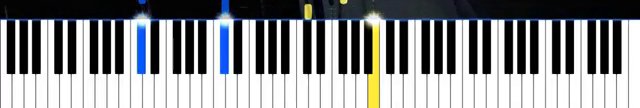


🎹 Detecting piano keys...
Detected 18 white keys and 33 black keys


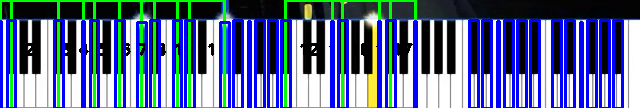


🎵 Analyzing video for note activity...

🎼 Detected notes mapping:
Key 0: C1
Key 1: D1
Key 2: E1
Key 3: F1
Key 4: G1
Key 5: A1
Key 6: B1
Key 7: C2
Key 8: D2
Key 9: E2
Key 10: F2
Key 11: G2
Key 12: A2
Key 13: B2
Key 14: C3
Key 15: D3
Key 16: E3
Key 17: F3

📝 Generating music sheet...


ValueError: "rgb(31.48744769874477,45.91352859135286,81.5599721059972)" is not defined as a named color in css3

In [28]:
import cv2
import numpy as np
import os
from collections import defaultdict
from IPython.display import Image, display
import music21  # For music sheet generation

# ---------- CONFIG ----------
VIDEO_PATH = '../../Data/video/piano_visualizer.mp4'
MAX_FRAMES = 500
MIN_BLACK_KEYS = 5  # Reduced for more flexibility
WHITE_PIXEL_RATIO = 0.4  # More lenient threshold
ROI_HEIGHT_RATIO = 0.3  # Increased search area
COLOR_SENSITIVITY = 30  # For detecting colored notes
MIN_NOTE_DURATION = 0.1  # seconds
NOTE_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# ---------- OUTPUT DIR ----------
os.makedirs("output_SYNtoSHEET", exist_ok=True)

# ---------- Piano Detection Functions ----------
def is_piano_like_frame(roi, min_black_keys=MIN_BLACK_KEYS, white_pixel_ratio=WHITE_PIXEL_RATIO):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding for better black key detection
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV, 11, 2)

    # Count white pixels (piano background)
    white_pixels = np.sum(gray > 200)
    total_pixels = gray.shape[0] * gray.shape[1]
    white_ratio = white_pixels / total_pixels

    # Detect black keys
    contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black_keys = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        if h > roi.shape[0] * 0.4 and w < roi.shape[1] * 0.1 and aspect_ratio < 0.2:
            black_keys.append((x, y, w, h))

    return white_ratio > white_pixel_ratio and len(black_keys) >= min_black_keys, white_ratio, len(black_keys)

def find_piano_region(video_path, max_frames=MAX_FRAMES, debug=False):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise Exception(f"❌ Failed to open video: {video_path}")

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    best_frame = None
    best_roi = None
    best_score = -1
    best_frame_index = 0
    best_roi_y = 0

    # Try different ROI positions (not just bottom)
    for frame_index in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break

        # Try different vertical positions for ROI
        for roi_y in range(0, frame_height - 100, 50):
            h_roi = int(frame_height * ROI_HEIGHT_RATIO)
            roi = frame[roi_y:roi_y+h_roi, 0:frame_width]

            is_piano, white_ratio, num_black = is_piano_like_frame(roi)
            score = white_ratio * num_black

            if debug:
                print(f"Frame {frame_index} Y:{roi_y}: White={white_ratio:.2f}, Black={num_black}, Score={score:.2f}")

            if score > best_score:
                best_score = score
                best_frame = frame
                best_roi = roi
                best_frame_index = frame_index
                best_roi_y = roi_y

    cap.release()

    if best_frame is None:
        raise Exception("❌ No piano-like region found in video.")

    return best_frame, best_roi, best_frame_index, best_roi_y, frame_width, frame_height, fps

def detect_keys_from_frame(roi, debug=False):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Use adaptive thresholding for better key separation
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV, 11, 2)

    # Find black keys
    contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black_keys = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if h > roi.shape[0] * 0.4 and w < roi.shape[1] * 0.1:
            black_keys.append((x, y, w, h))

    black_keys = sorted(black_keys, key=lambda b: b[0])
    black_x_centers = [x + w // 2 for x, y, w, h in black_keys]

    # Estimate white key positions based on black key spacing
    white_keys = []
    if len(black_x_centers) >= 2:
        # Calculate typical distances between black keys
        dists = np.diff(black_x_centers)
        median_dist = np.median(dists)

        # Group black keys into patterns (2-3-2 for octaves)
        patterns = []
        current_pattern = [black_x_centers[0]]

        for i in range(1, len(black_x_centers)):
            dist = black_x_centers[i] - black_x_centers[i-1]
            if dist < median_dist * 1.5:
                current_pattern.append(black_x_centers[i])
            else:
                patterns.append(current_pattern)
                current_pattern = [black_x_centers[i]]
        patterns.append(current_pattern)

        # Create white keys based on patterns
        for i, pattern in enumerate(patterns):
            # Left of first black key in pattern
            if i == 0:
                left_bound = 0
            else:
                left_bound = patterns[i-1][-1]

            # Right of last black key in pattern
            if i == len(patterns)-1:
                right_bound = roi.shape[1]
            else:
                right_bound = patterns[i+1][0]

            # Create white keys based on pattern type
            if len(pattern) == 2:  # C# D# pattern
                # Left white key (C)
                white_keys.append((left_bound, 0, pattern[0] - left_bound, roi.shape[0]))
                # Middle white key (D)
                white_keys.append((pattern[0], 0, pattern[1] - pattern[0], roi.shape[0]))
                # Right white key (E)
                white_keys.append((pattern[1], 0, right_bound - pattern[1], roi.shape[0]))
            elif len(pattern) == 3:  # F# G# A# pattern
                # Left white key (F)
                white_keys.append((left_bound, 0, pattern[0] - left_bound, roi.shape[0]))
                # Middle white keys (G, A)
                white_keys.append((pattern[0], 0, pattern[1] - pattern[0], roi.shape[0]))
                white_keys.append((pattern[1], 0, pattern[2] - pattern[1], roi.shape[0]))
                # Right white key (B)
                white_keys.append((pattern[2], 0, right_bound - pattern[2], roi.shape[0]))

    # Sort white keys by position
    white_keys = sorted(white_keys, key=lambda w: w[0])

    # Visualize detection
    vis = roi.copy()
    for i, (x, y, w, h) in enumerate(white_keys):
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(vis, str(i), (x + w//2 - 10, y + h//2),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    for x, y, w, h in black_keys:
        cv2.rectangle(vis, (x, y), (x + w, y + h), (255, 0, 0), 2)

    if debug:
        print(f"Detected {len(white_keys)} white keys and {len(black_keys)} black keys")

    return vis, white_keys, black_keys

# ---------- Note Detection Functions ----------
def detect_note_colors_in_roi(roi, white_keys, black_keys):
    """Detect active note colors in the ROI"""
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Find colored regions (excluding white/black piano keys)
    lower_color = np.array([0, 50, 50])
    upper_color = np.array([180, 255, 255])
    color_mask = cv2.inRange(hsv, lower_color, upper_color)

    # Find contours of colored regions
    contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    active_notes = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 50:  # Skip small areas
            continue

        # Get bounding box and color
        x, y, w, h = cv2.boundingRect(cnt)
        center_x = x + w // 2

        # Find which key this belongs to
        key_index = None
        for i, (wx, wy, ww, wh) in enumerate(white_keys):
            if wx <= center_x <= wx + ww:
                key_index = i
                break

        if key_index is not None:
            # Get average color in the region
            mask = np.zeros(roi.shape[:2], np.uint8)
            cv2.drawContours(mask, [cnt], -1, 255, -1)
            mean_color = cv2.mean(roi, mask=mask)[:3]
            active_notes.append((key_index, mean_color))

    return active_notes

def analyze_video(video_path, white_keys, black_keys, roi_y, roi_height, fps):
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Data structure to track notes: {key_index: [(start_frame, end_frame, color)]}
    note_activity = defaultdict(list)
    current_notes = {}  # {key_index: (start_frame, color)}

    for frame_num in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break

        roi = frame[roi_y:roi_y+roi_height, 0:frame_width]
        active_notes = detect_note_colors_in_roi(roi, white_keys, black_keys)

        # Check for newly pressed notes
        active_keys = {key_idx for key_idx, _ in active_notes}
        for key_idx, color in active_notes:
            if key_idx not in current_notes:
                current_notes[key_idx] = (frame_num, color)

        # Check for released notes
        released_keys = set(current_notes.keys()) - active_keys
        for key_idx in released_keys:
            start_frame, color = current_notes.pop(key_idx)
            duration = frame_num - start_frame
            if duration > MIN_NOTE_DURATION * fps:  # Filter very short notes
                note_activity[key_idx].append((start_frame, frame_num, color))

    # Add any remaining active notes at the end
    for key_idx, (start_frame, color) in current_notes.items():
        duration = total_frames - start_frame
        if duration > MIN_NOTE_DURATION * fps:
            note_activity[key_idx].append((start_frame, total_frames, color))

    cap.release()
    return note_activity

def map_keys_to_notes(white_keys, black_keys):
    """Map detected key indices to musical notes"""
    # This assumes the piano starts at C1 (could be adjusted)
    notes = []
    white_note_indices = [0, 2, 4, 5, 7, 9, 11]  # C, D, E, F, G, A, B in an octave

    for i in range(len(white_keys)):
        octave = (i // 7) + 1
        note_index = i % 7
        note_name = NOTE_NAMES[white_note_indices[note_index]] + str(octave)
        notes.append(note_name)

    return notes

def create_music_sheet(note_activity, key_to_note_map, fps):
    """Create a music21 stream from the detected notes"""
    stream = music21.stream.Stream()

    for key_idx, note_intervals in note_activity.items():
        note_name = key_to_note_map[key_idx]

        for start_frame, end_frame, color in note_intervals:
            start_time = start_frame / fps
            duration = (end_frame - start_frame) / fps

            # Create note
            note = music21.note.Note(note_name)
            note.duration.quarterLength = duration * 2  # Adjust tempo as needed
            note.offset = start_time * 2  # Adjust tempo as needed

            # Add color information (for visualization)
            note.style.color = f"rgb({color[2]},{color[1]},{color[0]})"

            stream.insert(note.offset, note)

    return stream

# ---------- Main Processing ----------
def main():
    print("🎹 Synthesia Video to Sheet Music Converter")

    # 1. Find piano region in video
    print("\n🔍 Detecting piano region...")
    best_frame, best_roi, frame_index, roi_y, frame_width, frame_height, fps = find_piano_region(
        VIDEO_PATH, debug=True)

    print(f"\n✅ Piano found at frame {frame_index}, Y position: {roi_y}")
    cv2.imwrite("output_SYNtoSHEET/piano_roi.png", best_roi)
    display(Image(filename="output_SYNtoSHEET/piano_roi.png"))

    # 2. Detect piano keys
    print("\n🎹 Detecting piano keys...")
    detected_img, white_keys, black_keys = detect_keys_from_frame(best_roi, debug=True)
    cv2.imwrite("output_SYNtoSHEET/detected_keys.png", detected_img)
    display(Image(filename="output_SYNtoSHEET/detected_keys.png"))

    # 3. Analyze entire video for note activity
    print("\n🎵 Analyzing video for note activity...")
    roi_height = best_roi.shape[0]
    note_activity = analyze_video(VIDEO_PATH, white_keys, black_keys, roi_y, roi_height, fps)

    # 4. Map keys to musical notes
    key_to_note_map = map_keys_to_notes(white_keys, black_keys)
    print("\n🎼 Detected notes mapping:")
    for i, note in enumerate(key_to_note_map):
        print(f"Key {i}: {note}")

    # 5. Create music sheet
    print("\n📝 Generating music sheet...")
    music_stream = create_music_sheet(note_activity, key_to_note_map, fps)

    # Save to MusicXML and MIDI
    music_stream.write('musicxml', fp='output_SYNtoSHEET/sheet_music.musicxml')
    music_stream.write('midi', fp='output_SYNtoSHEET/sheet_music.mid')

    print("\n🎉 Conversion complete! Files saved in output_SYNtoSHEET/ directory")

if __name__ == "__main__":
    main()